In [1]:
print('chat am i cooked ?')

chat am i cooked ?


In [2]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import pennylane as qml
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import time

In [3]:
# Seed generator from alphabetic string
def seed_gen(string):
    num_str = [ord(letter) - 96 for letter in string]
    # seed must be between 0 and 2**32 - 1
    return(np.mod(int(''.join(map(str,num_str))),2**32 - 1))

seeds = ['matterlab', 'alba', 'jakob', 'alan']

s = 0 # default seed, used in the main article results
random.seed(seed_gen(seeds[s])) 

In [4]:
num_qubits = 4
dev = qml.device("default.qubit", wires=num_qubits)

c:\Users\edgar\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\edgar\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Ground state energy')

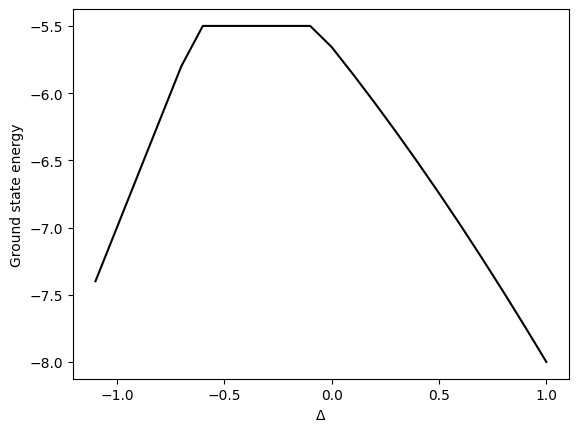

In [ ]:
def spin_ham_XXZ(n, lam, delta):
    coeff = []
    operators = []
    for i in range(n-1):
        # XX coupling
        operators.append(qml.PauliX(i) @ qml.PauliX(i+1))
        coeff.append(1.0)

        # YY coupling
        operators.append(qml.PauliY(i) @ qml.PauliY(i+1))
        coeff.append(1.0)
        
        # ZZ coupling
        operators.append(qml.PauliZ(i) @ qml.PauliZ(i+1))
        coeff.append(delta)
    
    # periodic boundary conditions (just so that it wraps around)
    operators.append(qml.PauliX(n-1) @ qml.PauliX(0))
    coeff.append(1.0)
    operators.append(qml.PauliY(n-1) @ qml.PauliY(0))
    coeff.append(1.0)
    operators.append(qml.PauliZ(n-1) @ qml.PauliZ(0))
    coeff.append(delta)

    #transverse field
    for i in range(n):
        operators.append(qml.PauliZ(i))
        coeff.append(lam)

    return qml.Hamiltonian(coeff, operators)

# Function to compute the ground state energy
def ground_state(n, lam, delta):
    H = spin_ham_XXZ(n, lam, delta)
    H_matrix = qml.matrix(H, wire_order=list(range(n)))
    eigvals = np.linalg.eigvals(H_matrix)
    return min(eigvals)


exac = []
delta = np.arange(-1.1, 1.1, 0.1)
lam = 0.75
for d in delta:
    E0 = ground_state(n=num_qubits, delta=d, lam=lam)
    exac.append(E0)
plt.plot(delta, exac, label='Exact', color='black')
plt.xlabel('Δ')
plt.ylabel('Ground state energy')


In [6]:
# function to generate single qubit rotation gates
def single_rot(theta, phi, target):
    qml.RZ(theta, wires=target) 
    qml.RY(phi, wires=target)

In [7]:
# Function to generate encoding and processing layers
def processing_layer(proc_params, target, n, num_layers):
    for i in range(num_layers):
        p = i % 2  #even/odd check
        for j in range(n):
            theta, phi = proc_params[i][j]
            single_rot(theta, phi, target[j])
        for j in range(p, n-1, 2):
            qml.CNOT(wires=[target[j], target[j+1]])

def encoding_layer(enc_params, w_params, delta, target, n, num_layers):
    for i in range(num_layers):
        p = i % 2
        for j in range(n):
            theta, phi = enc_params[i][j]
            wth, wph = w_params[i][j]
            single_rot(wth * delta + theta, wph * delta + phi, target[j])
        for j in range(p, n - 1, 2):
            qml.CNOT(wires=[target[j], target[j + 1]])


<class 'numpy.ndarray'>
(<Figure size 1500x500 with 1 Axes>, <Axes: >)


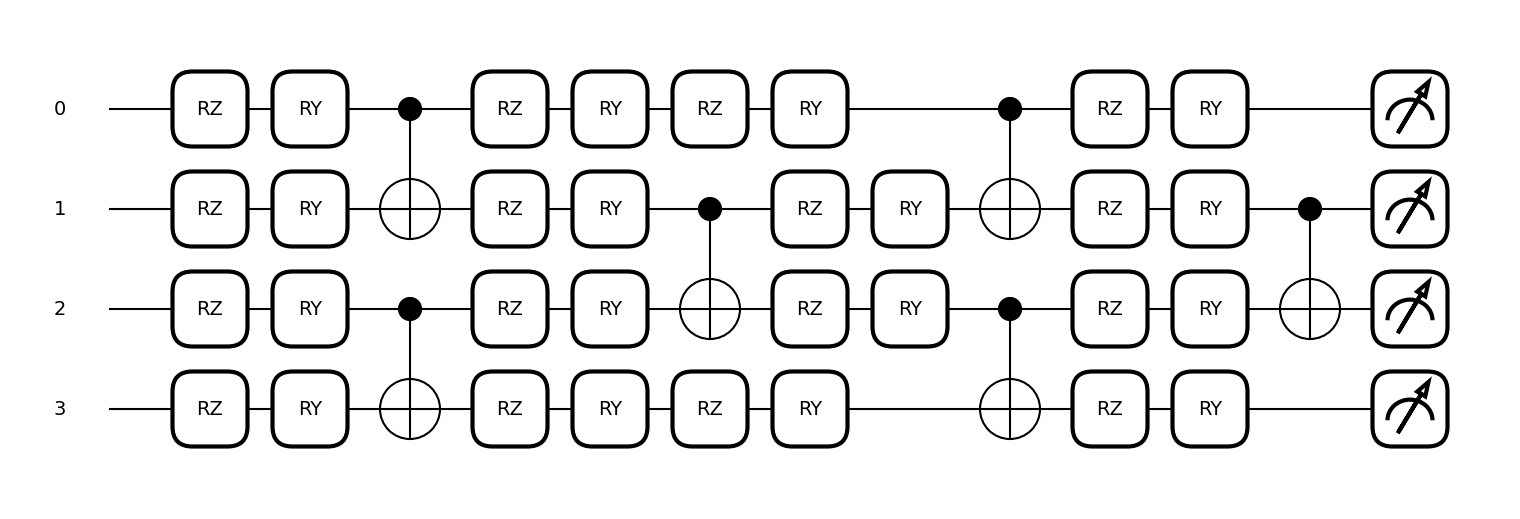

In [8]:
# Function to check if the ansatz circuit matches the one in the paper
@qml.qnode(dev)
def circuit(proc_params, enc_params, w_params, n, lam, delta):
    ham = spin_ham_XXZ(n, lam, delta)
    # encoding layer
    encoding_layer(enc_params,w_params, delta, range(n), n, 2)
    # processing layer
    processing_layer(proc_params, range(n), n, 2)

    return qml.expval(ham)


num_layers = 2

w_params = np.random.uniform(0, np.pi, (num_layers, num_qubits, 2)) 
proc_params = np.random.uniform(0, np.pi, (num_layers, num_qubits, 2))
enc_params = np.random.uniform(0, np.pi, (num_layers, num_qubits, 2))


print(type(proc_params))
drawer = qml.draw_mpl(circuit)
print(drawer(proc_params, enc_params, w_params, num_qubits, lam, 0.8)) 


<class 'numpy.ndarray'>
0.3943783137166746


Text(0.5, 1.0, 'Expectation value of Hamiltonian vs Delta')

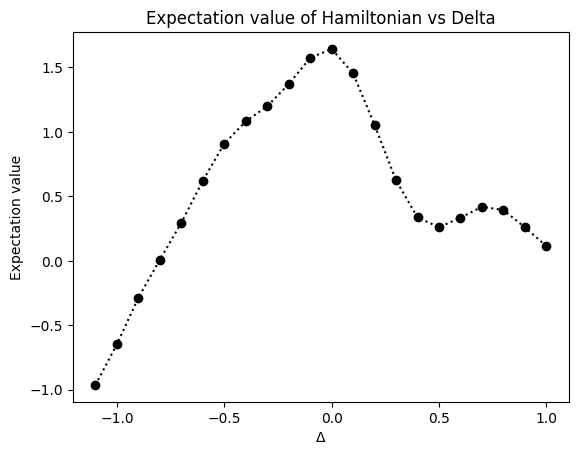

In [9]:
@qml.qnode(dev)
def expectation_value(proc_params,enc_params, w_params, n, lam, delta):
    
    ham = spin_ham_XXZ(n, lam, delta)
    # encoding layer
    encoding_layer(enc_params,w_params, delta, range(n), n, 2)
    # processing layer
    processing_layer(proc_params, range(n), n, 1)
    return qml.expval(ham)

# little check on the type of the output
exp_value = expectation_value(proc_params, enc_params, w_params, n=num_qubits, lam=lam, delta=0.8)
print(type(exp_value))
print(exp_value)

# compute the expectation value for different delta values in the range [-1.1, 1.1] defined above
exp_vals = []
for d in delta:
    exp_val = expectation_value(proc_params, enc_params, w_params, n=num_qubits, lam=lam, delta=d)
    exp_vals.append(exp_val)

   

plt.plot(delta, exp_vals, marker='o', linestyle=':', color='black')
plt.xlabel('Δ')
plt.ylabel('Expectation value')
plt.title('Expectation value of Hamiltonian vs Delta')

### Meta-VQE with Adam optimizer

In [10]:
# generate circuit
@qml.qnode(dev, diff_method="best")
def meta_vqe_circuit(proc_params, enc_params, w_params, n, lam, delta, num_layers):
    # encoding layer
    encoding_layer(enc_params,w_params, delta, range(n), n, num_layers)
    # processing layer
    processing_layer(proc_params, range(n), n, 1)

    ham = spin_ham_XXZ(n, lam, delta)
    return qml.expval(ham)


def loss_function(proc_params, enc_params, w_params, n, lam, deltas):
    loss = 0
    for delta in deltas:
        loss += meta_vqe_circuit(proc_params, enc_params, w_params, n, lam, delta, num_layers)
    return loss/len(deltas)

In [11]:
# Generating the training set 
n_train = 20
n_test = 100

delta_min = 1.1
delta_max = -1.1
deltas_train = [delta_min + (delta_max - delta_min) * i / (n_train - 1) for i in range(n_train)]
lam = 0.75

#number of layers for each type of layer
enc_n_layers = 2
proc_n_layers = 1

init_proc_params = np.random.uniform(0, np.pi, (proc_n_layers, num_qubits, 2))
init_enc_params = np.random.uniform(0, np.pi, (enc_n_layers, num_qubits, 2))
init_w_params = np.random.uniform(0, np.pi, (enc_n_layers, num_qubits, 2))


In [12]:
opt = qml.AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.999)
losses = []

# Initialize current parameters with initial values
current_proc_params = init_proc_params.copy()
current_enc_params = init_enc_params.copy()
current_w_params = init_w_params.copy()

current_proc_params = qml.numpy.array(current_proc_params, requires_grad=True)
current_enc_params = qml.numpy.array(current_enc_params, requires_grad=True)
current_w_params = qml.numpy.array(current_w_params, requires_grad=True)

# Track best parameters based on loss
best_loss = float('inf')
best_proc_params = None
best_enc_params = None
best_w_params = None

for i in range(n_train):
    
    (current_proc_params, current_enc_params, current_w_params), curr_loss = opt.step_and_cost(
        lambda pp, ep, wp: loss_function(pp, ep, wp, num_qubits, lam, deltas_train), current_proc_params,
        current_enc_params, current_w_params)
    losses.append(curr_loss)
    
    # Store best parameters
    if curr_loss < best_loss:
        best_loss = curr_loss
        best_proc_params = current_proc_params.copy()
        best_enc_params = current_enc_params.copy()
        best_w_params = current_w_params.copy()
    
    print(f"Step {i}: Loss = {curr_loss:.6f}")
    # print('best encoding params:', best_enc_params)
    # print('best weight params:', best_w_params)

# Store final trained parameters (using best found parameters)
trained_proc_params = best_proc_params
trained_enc_params = best_enc_params
trained_w_params = best_w_params

Step 0: Loss = 0.060507
Step 1: Loss = -0.651712
Step 2: Loss = -1.308981
Step 3: Loss = -1.866325
Step 4: Loss = -2.297636
Step 5: Loss = -2.595761
Step 6: Loss = -2.797825
Step 7: Loss = -2.949187
Step 8: Loss = -3.064130
Step 9: Loss = -3.161471
Step 10: Loss = -3.267047
Step 11: Loss = -3.377796
Step 12: Loss = -3.477751
Step 13: Loss = -3.562169
Step 14: Loss = -3.638232
Step 15: Loss = -3.713088
Step 16: Loss = -3.788631
Step 17: Loss = -3.862629
Step 18: Loss = -3.930061
Step 19: Loss = -3.984287


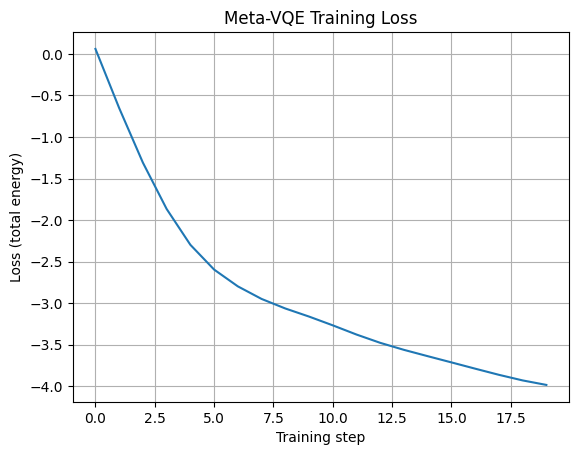

In [13]:
plt.plot(losses)
plt.xlabel("Training step")
plt.ylabel("Loss (total energy)")
plt.title("Meta-VQE Training Loss")
plt.grid()
plt.show()

In [14]:
x_train = deltas_train 
y_train_ex = []
y_train_metaVQE = []
error_train_metaVQE = []

# Loop over all training points
for delta in deltas_train:
    # Use trained parameters to evaluate the circuit
    pred_energy = meta_vqe_circuit(trained_proc_params, trained_enc_params, trained_w_params, num_qubits, lam, delta, num_layers)

    # Reference exact solution 
    true_energy = ground_state(num_qubits, lam, delta)

    print(delta, true_energy, pred_energy, abs(pred_energy-true_energy))
    # Store results
    y_train_metaVQE.append(pred_energy)
    y_train_ex.append(true_energy)
    error_train_metaVQE.append(abs(pred_energy - true_energy))


1.1 (-8.26959636219742+0j) -4.925951841300268 3.3436445208971524
0.9842105263157895 (-7.95796873509+0j) -5.5580819334893805 2.399886801600619
0.868421052631579 (-7.6543264101527715+0j) -5.516276882005936 2.1380495281468352
0.7526315789473685 (-7.3589643096888055+0j) -5.188524056651831 2.1704402530369746
0.6368421052631579 (-7.07215568740227+0j) -4.8784407123615265 2.193714975040743
0.5210526315789474 (-6.7941469336868305+0j) -4.633505313250433 2.1606416204363974
0.4052631578947369 (-6.525152542288209-9.267875949547103e-33j) -4.386343463883452 2.1388090784047575
0.2894736842105263 (-6.265350454327081-1.3312238487423027e-32j) -4.098634412753415 2.1667160415736655
0.17368421052631577 (-6.014877999336965+0j) -3.7544505254712575 2.260427473865708
0.05789473684210522 (-5.773828639527445+0j) -3.329279961787014 2.444548677740431
-0.05789473684210522 (-5.542249692159029+0j) -2.8851459540463464 2.6571037381126823
-0.17368421052631589 (-5.499999999999999+0j) -2.675018858308114 2.824981141691885
-

In [15]:
deltas_test = [random.uniform(delta_min, delta_max) for _ in range(n_test)]
deltas_test.sort()

x_test = deltas_test
y_test_ex = []
y_test_metaVQE = []
error_test_metaVQE = []

# Inference on test points
for delta in x_test:
    pred_energy = meta_vqe_circuit(trained_proc_params, trained_enc_params, trained_w_params, num_qubits, lam, delta, num_layers)
    exact_energy = ground_state(num_qubits, lam, delta) 

    y_test_metaVQE.append(pred_energy)
    y_test_ex.append(exact_energy)
    error_test_metaVQE.append(abs(pred_energy - exact_energy))


c:\Users\edgar\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\edgar\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


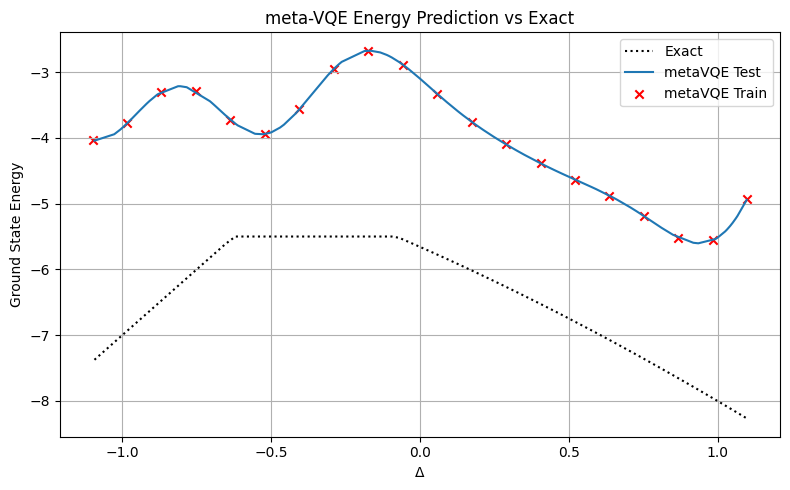

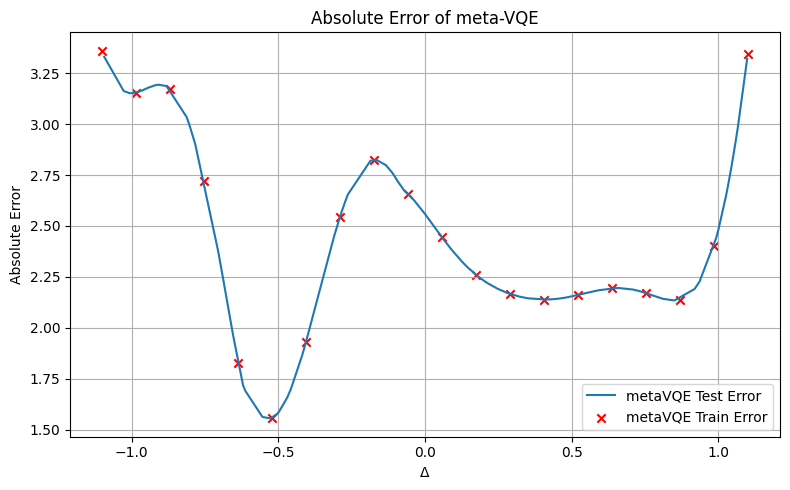

In [16]:
# Ground state energy plot
plt.figure(figsize=(8, 5))
plt.plot(x_test, y_test_ex, color="black", linestyle=":", label="Exact")
plt.plot(x_test, y_test_metaVQE, linestyle="-", label="metaVQE Test")
plt.scatter(x_train, y_train_metaVQE, color="red", marker="x", label="metaVQE Train")
plt.xlabel(r"$\Delta$")
plt.ylabel("Ground State Energy")
plt.title("meta-VQE Energy Prediction vs Exact")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Absolute error plot
plt.figure(figsize=(8, 5))
plt.plot(x_test, error_test_metaVQE, linestyle="-", label="metaVQE Test Error")
plt.scatter(x_train, error_train_metaVQE, color="red", marker="x", label="metaVQE Train Error")
plt.xlabel(r"$\Delta$")
plt.ylabel("Absolute Error")
plt.title("Absolute Error of meta-VQE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Meta-VQE with BFGS optimizer

In [17]:
w_params = np.random.uniform(0, np.pi, (enc_n_layers,num_qubits, 2))
proc_params = np.random.uniform(0, np.pi, (proc_n_layers,num_qubits, 2))
enc_params = np.random.uniform(0, np.pi, (enc_n_layers,num_qubits, 2))


In [18]:
print(proc_params.shape)


(1, 4, 2)


In [19]:
# generate circuit
@qml.qnode(dev, diff_method="finite-diff")
def meta_vqe_circuit(proc_params, enc_params, w_params, n, lam, delta, num_layers):
    # encoding layer
    encoding_layer(enc_params,w_params, delta, range(n), n, num_layers)
    # processing layer
    processing_layer(proc_params, range(n), n, 1)

    ham = spin_ham_XXZ(n, lam, delta)
    return qml.expval(ham)


In [20]:
from scipy.optimize import minimize
# we need to flatten the parameters to be able to use the minimize function
flat_params = np.concatenate([proc_params.flatten(), enc_params.flatten(), w_params.flatten()])

# Define shapes for reshaping later
proc_shape = proc_params.shape
enc_shape = enc_params.shape
w_shape = w_params.shape

proc_size = np.prod(proc_shape)
enc_size = np.prod(enc_shape)

losses = []

# Define the cost function
def cost_fn(flat_params):
    # Reshape flat_params back to original shapes
    
    proc_params_reshaped = flat_params[:proc_size].reshape(proc_shape)
    enc_params_reshaped = flat_params[proc_size:proc_size + enc_size].reshape(enc_shape)
    w_params_reshaped = flat_params[proc_size + enc_size:].reshape(w_shape)
    
    # Compute the loss
    loss = loss_function(proc_params_reshaped, enc_params_reshaped, w_params_reshaped, num_qubits, lam, deltas_train)
    losses.append(loss)
    return loss


result = minimize(cost_fn, flat_params, method='BFGS', jac= '2-point', options={'maxiter': 100})

# Extract optimized parameters
optimized_flat_params = result.x
trained_proc_params = optimized_flat_params[:proc_size].reshape(proc_shape)
trained_enc_params = optimized_flat_params[proc_size:proc_size + enc_size].reshape(enc_shape)
trained_w_params = optimized_flat_params[proc_size + enc_size:].reshape(w_shape)

In [21]:
print(proc_shape)


(1, 4, 2)


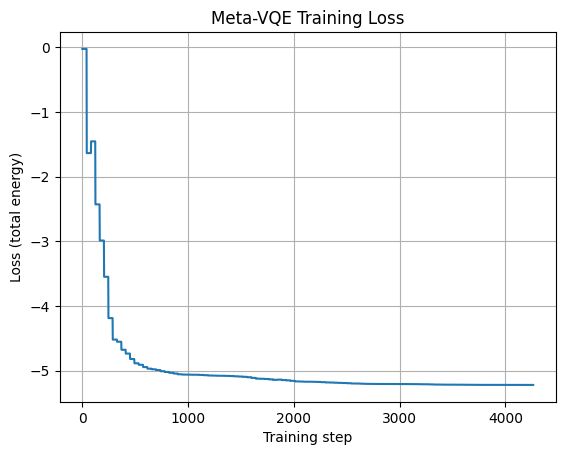

In [22]:
plt.plot(losses)
plt.xlabel("Training step")
plt.ylabel("Loss (total energy)")
plt.title("Meta-VQE Training Loss")
plt.grid()
plt.show()

In [23]:
delta_sample = 0.8

before = meta_vqe_circuit(proc_params, enc_params, w_params, num_qubits, lam, delta_sample, num_layers)
after  = meta_vqe_circuit(trained_proc_params, trained_enc_params, trained_w_params, num_qubits, lam, delta_sample, num_layers)

print("Before training:", before)
print("After training:", after)

Before training: 0.28391052587209
After training: -5.70136907968452


In [24]:
x_train = deltas_train 
y_train_ex = []
y_train_metaVQE = []
error_train_metaVQE = []

# Loop over all training points
for delta in deltas_train:
    # Use trained parameters to evaluate the circuit
    pred_energy = meta_vqe_circuit(trained_proc_params, trained_enc_params, trained_w_params, num_qubits, lam, delta, num_layers)

    # Reference exact solution 
    true_energy = ground_state(num_qubits, lam, delta)

    # print(delta, true_energy, pred_energy, abs(pred_energy-true_energy))
    # Store results
    y_train_metaVQE.append(pred_energy)
    y_train_ex.append(true_energy)
    error_train_metaVQE.append(abs(pred_energy - true_energy))
    print(delta, true_energy, pred_energy, abs(pred_energy-true_energy))


1.1 (-8.26959636219742+0j) -5.900002547175094 2.369593815022326
0.9842105263157895 (-7.95796873509+0j) -5.884010718480257 2.073958016609743
0.868421052631579 (-7.6543264101527715+0j) -5.780759577447736 1.8735668327050359
0.7526315789473685 (-7.3589643096888055+0j) -5.643645570973323 1.7153187387154825
0.6368421052631579 (-7.07215568740227+0j) -5.501494819743424 1.5706608676588454
0.5210526315789474 (-6.7941469336868305+0j) -5.3569733434123545 1.437173590274476
0.4052631578947369 (-6.525152542288209-9.267875949547103e-33j) -5.1928630924755055 1.3322894498127038
0.2894736842105263 (-6.265350454327081-1.3312238487423027e-32j) -4.985003224021448 1.2803472303056322
0.17368421052631577 (-6.014877999336965+0j) -4.720011562284773 1.2948664370521925
0.05789473684210522 (-5.773828639527445+0j) -4.412560265369503 1.3612683741579419
-0.05789473684210522 (-5.542249692159029+0j) -4.113437210465685 1.4288124816933436
-0.17368421052631589 (-5.499999999999999+0j) -3.900830481401379 1.5991695185986203
-

In [25]:
deltas_test = [random.uniform(delta_min, delta_max) for _ in range(n_test)]
deltas_test.sort()

x_test = deltas_test
y_test_ex = []
y_test_metaVQE = []
error_test_metaVQE = []

# Inference on test points
for delta in x_test:
    pred_energy = meta_vqe_circuit(trained_proc_params, trained_enc_params, trained_w_params, num_qubits, lam, delta, num_layers)
    exact_energy = ground_state(num_qubits, lam, delta) 

    y_test_metaVQE.append(pred_energy)
    y_test_ex.append(exact_energy)
    error_test_metaVQE.append(abs(pred_energy - exact_energy))
    print(delta, exact_energy, pred_energy, abs(pred_energy - exact_energy))


-1.079805404209048 (-7.319221616836192+0j) -7.04916159130407 0.2700600255321213
-1.055044114129044 (-7.220176456516176+0j) -6.990418697971283 0.22975775854489378
-1.015489034056063 (-7.061956136224252+0j) -6.875355145780594 0.18660099044365808
-0.9983551750242738 (-6.993420700097095+0j) -6.817858117573226 0.17556258252386936
-0.9913351878150354 (-6.9653407512601415+0j) -6.793031002437577 0.17230974882256422
-0.9258673219783407 (-6.703469287913363+0j) -6.528895435578755 0.17457385233460787
-0.9134350315477566 (-6.6537401261910265+0j) -6.4726984543970865 0.18104167179394004
-0.8944989444068367 (-6.577995777627347+0j) -6.38386221173683 0.19413356589051656
-0.8835061647201099 (-6.53402465888044+0j) -6.3306161627962645 0.2034084960841751
-0.8794453278233485 (-6.517781311293394+0j) -6.310653761600529 0.2071275496928653
-0.8708797987649557 (-6.483519195059823+0j) -6.268052147687319 0.21546704737250355
-0.867390339097827 (-6.469561356391308+0j) -6.250510672923479 0.2190506834678292
-0.85744410

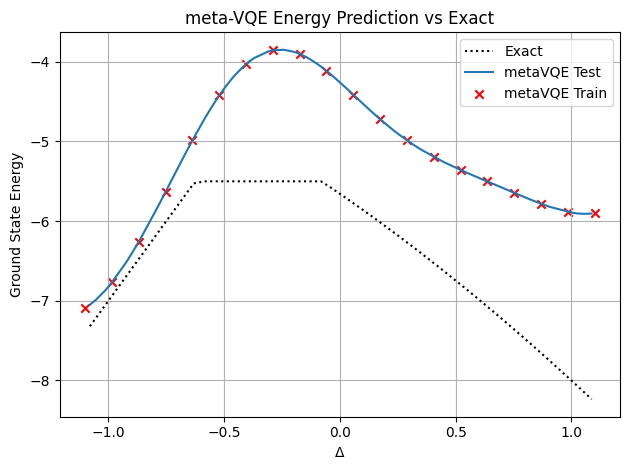

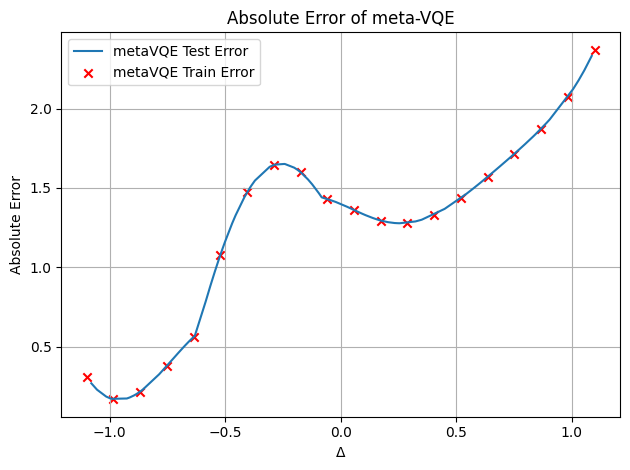

In [26]:
# Ground state energy plot
plt.plot(x_test, y_test_ex, color="black", linestyle=":", label="Exact")
plt.plot(x_test, y_test_metaVQE, linestyle="-", label="metaVQE Test")
plt.scatter(x_train, y_train_metaVQE, color="red", marker="x", label="metaVQE Train")
plt.xlabel(r"$\Delta$")
plt.ylabel("Ground State Energy")
plt.title("meta-VQE Energy Prediction vs Exact")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Absolute error plot
plt.plot(x_test, error_test_metaVQE, linestyle="-", label="metaVQE Test Error")
plt.scatter(x_train, error_train_metaVQE, color="red", marker="x", label="metaVQE Train Error")
plt.xlabel(r"$\Delta$")
plt.ylabel("Absolute Error")
plt.title("Absolute Error of meta-VQE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Standard VQE

In [47]:
# the main difference between VQE and meta-VQE is that all layers are equivalent to processing layers
@qml.qnode(dev, diff_method="finite-diff")
def vqe_circuit(proc_params, n, lam, delta):
    processing_layer(proc_params, range(n), n, enc_n_layers+proc_n_layers)

    ham = spin_ham_XXZ(n, lam, delta)
    return qml.expval(ham)

In [48]:
proc_params = random.uniform(0, np.pi, (proc_n_layers+ enc_n_layers,num_qubits, 2))

In [49]:
# Initialize parameters
vqe_flat_params = proc_params.flatten()
vqe_proc_shape = proc_params.shape
vqe_proc_size = np.prod(vqe_proc_shape)

losses = []
y_VQE = []
error_yVQE = []

# Define the cost function for each delta value
def cost_fn(params, delta):
    params_reshaped = params.reshape(vqe_proc_shape)
    return vqe_circuit(params_reshaped, num_qubits, lam, delta)

for i in range(n_train):
    delta = deltas_train[i]
    
    # Create a closure for this specific delta
    objective = lambda p: cost_fn(p, delta)
    
    # Optimize
    result = minimize(objective, vqe_flat_params, method='BFGS', 
                     jac='2-point', options={'maxiter': 100})
    
    # Store results
    loss = cost_fn(result.x, delta)
    losses.append(loss)
    y_VQE.append(loss)
    error_yVQE.append(abs(loss - y_train_ex[i]))
    
    print(deltas_train[i], y_train_ex[i], loss, abs(loss - y_train_ex[i]))

1.1 (-8.26959636219742+0j) -6.530363222781855 1.7392331394155658
0.9842105263157895 (-7.95796873509+0j) -6.354538163587344 1.6034305715026553
0.868421052631579 (-7.6543264101527715+0j) -6.194106984425014 1.4602194257277574
0.7526315789473685 (-7.3589643096888055+0j) -5.847250026547217 1.5117142831415888
0.6368421052631579 (-7.07215568740227+0j) -5.90769072172411 1.1644649656781594
0.5210526315789474 (-6.7941469336868305+0j) -5.779857602222437 1.0142893314643935
0.4052631578947369 (-6.525152542288209-9.267875949547103e-33j) -5.660509874805211 0.8646426674829986
0.2894736842105263 (-6.265350454327081-1.3312238487423027e-32j) -5.548580218957969 0.7167702353691112
0.17368421052631577 (-6.014877999336965+0j) -5.443374497281875 0.5715035020550907
0.05789473684210522 (-5.773828639527445+0j) -5.344500461105983 0.4293281784214624
-0.05789473684210522 (-5.542249692159029+0j) -5.251868561247349 0.2903811309116797
-0.17368421052631589 (-5.499999999999999+0j) -5.165838793827689 0.33416120617231027


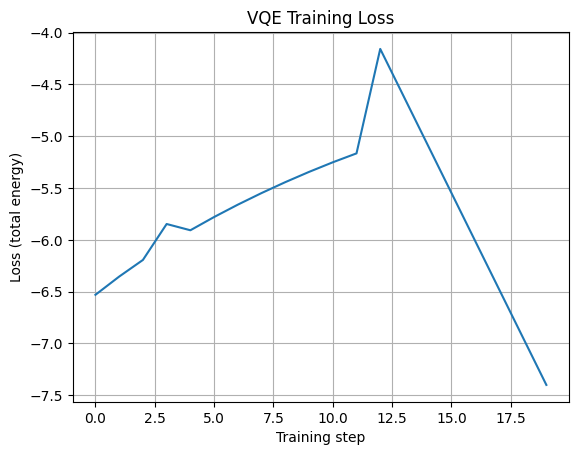

In [50]:
plt.plot(losses)
plt.xlabel("Training step")
plt.ylabel("Loss (total energy)")
plt.title("VQE Training Loss")
plt.grid()
plt.show()

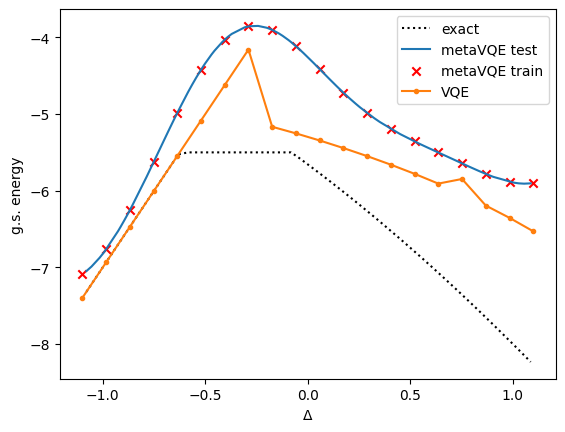

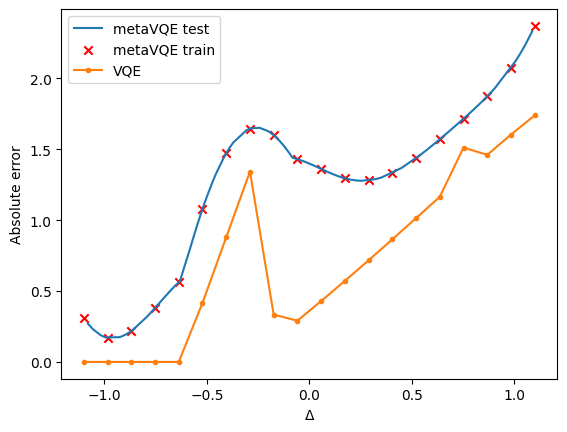

In [51]:
plt.plot(x_test, y_test_ex, color="black", ls=":", label="exact")
plt.plot(x_test, y_test_metaVQE,  ls="-", label="metaVQE test")
plt.scatter(x_train, y_train_metaVQE, color="red", marker="x", label="metaVQE train")
plt.plot(x_train, y_VQE,  marker=".", label="VQE")
plt.xlabel("Δ")
plt.ylabel('g.s. energy')
plt.legend()
plt.show()


plt.plot(x_test, error_test_metaVQE, ls="-", label="metaVQE test")
plt.scatter(x_train, error_train_metaVQE, marker="x", color="red", label="metaVQE train")
plt.plot(x_train, error_yVQE, marker=".", label="VQE")
plt.xlabel("Δ")
plt.ylabel("Absolute error")
plt.legend()
plt.show()



### OPT-meta-VQE

In [33]:
@qml.qnode(dev, diff_method="finite-diff")
def opt_meta_vqe_circuit(proc_params, enc_params, w_params, n, lam, delta, num_layers):
    # encoding layer
    encoding_layer(enc_params,w_params, delta, range(n), n, num_layers)
    # processing layer
    processing_layer(proc_params, range(n), n, 1)

    ham = spin_ham_XXZ(n, lam, delta)
    return qml.expval(ham)

In [34]:
# Initialize the parameters
opt_proc_params = trained_proc_params.copy()
opt_enc_params = trained_enc_params.copy()
opt_w_params = trained_w_params.copy()

In [35]:
opt_flat_params = np.concatenate([opt_proc_params.flatten(), opt_enc_params.flatten(), opt_w_params.flatten()])

# Define shapes for reshaping later
proc_shape = opt_proc_params.shape
enc_shape = opt_enc_params.shape
w_shape = opt_w_params.shape

proc_size = np.prod(proc_shape)
enc_size = np.prod(enc_shape)

In [36]:
y_opt_metaVQE = []
error_y_opt_metaVQE = []

# Define the cost function
def opt_cost_fn(flat_params, delta):
    # Reshape flat_params back to original shapes
    
    proc_params_reshaped = flat_params[:proc_size].reshape(proc_shape)
    enc_params_reshaped = flat_params[proc_size:proc_size + enc_size].reshape(enc_shape)
    w_params_reshaped = flat_params[proc_size + enc_size:].reshape(w_shape)
    
    return opt_meta_vqe_circuit(proc_params_reshaped, enc_params_reshaped, w_params_reshaped, num_qubits, lam, delta, num_layers)

for i in range(n_train):
    delta = deltas_train[i]
    
    # Create a closure for this specific delta
    opt_objective = lambda opt_flat_params: opt_cost_fn(opt_flat_params, delta)
    
    # Optimize
    opt_result = minimize(opt_objective, opt_flat_params, method='BFGS', 
                     jac='2-point', options={'maxiter': 100})
    
    # Store results
    opt_loss = opt_cost_fn(opt_result.x, delta)
    y_opt_metaVQE.append(opt_loss)
    error_y_opt_metaVQE.append(abs(opt_loss - y_train_ex[i]))
    
    # Update parameters for next iteration
    flat_params = opt_result.x.copy()
    print(deltas_train[i], y_train_ex[i], opt_loss, abs(opt_loss - y_train_ex[i]))


1.1 (-8.26959636219742+0j) -6.530363222738236 1.7392331394591842
0.9842105263157895 (-7.95796873509+0j) -6.3545381599265 1.6034305751634994
0.868421052631579 (-7.6543264101527715+0j) -6.19410698419766 1.4602194259551116
0.7526315789473685 (-7.3589643096888055+0j) -6.045389083866727 1.3135752258220785
0.6368421052631579 (-7.07215568740227+0j) -5.9076907217326795 1.1644649656695902
0.5210526315789474 (-6.7941469336868305+0j) -5.779857602370095 1.0142893313167356
0.4052631578947369 (-6.525152542288209-9.267875949547103e-33j) -5.660509874813647 0.8646426674745626
0.2894736842105263 (-6.265350454327081-1.3312238487423027e-32j) -5.548580218677211 0.7167702356498697
0.17368421052631577 (-6.014877999336965+0j) -5.443374497259903 0.5715035020770625
0.05789473684210522 (-5.773828639527445+0j) -5.344500461240987 0.4293281782864584
-0.05789473684210522 (-5.542249692159029+0j) -5.251868561108325 0.2903811310507036
-0.17368421052631589 (-5.499999999999999+0j) -4.781751087237376 0.7182489127626228
-0

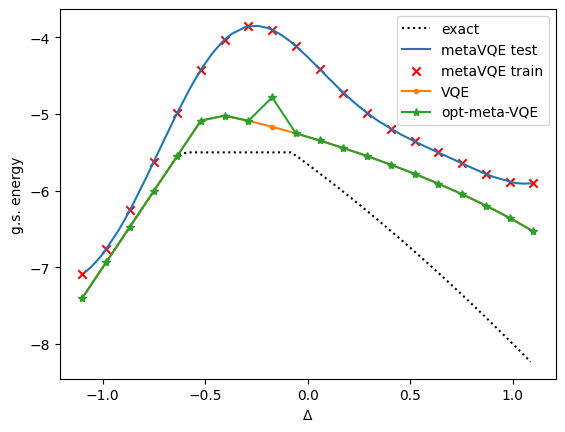

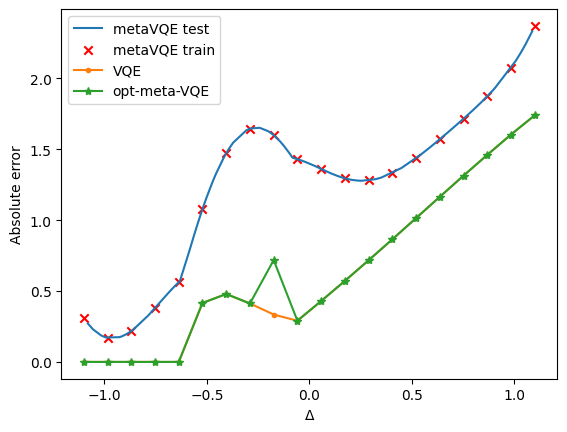

In [37]:
plt.plot(x_test, y_test_ex, color="black", ls=":", label="exact")
plt.plot(x_test, y_test_metaVQE,  ls="-", label="metaVQE test")
plt.scatter(x_train, y_train_metaVQE, color="red", marker="x", label="metaVQE train")
plt.plot(x_train, y_VQE,  marker=".", label="VQE")
plt.plot(x_train, y_opt_metaVQE, marker="*", label="opt-meta-VQE")


plt.xlabel("Δ")
plt.ylabel('g.s. energy')
plt.legend()

plt.show()

# Absolute error

plt.plot(x_test, error_test_metaVQE, ls="-", label="metaVQE test")
plt.scatter(x_train, error_train_metaVQE, marker="x", color="red", label="metaVQE train")
plt.plot(x_train, error_yVQE, marker=".", label="VQE")
plt.plot(x_train, error_y_opt_metaVQE, marker="*", label="opt-meta-VQE")


plt.xlabel("Δ")
plt.ylabel("Absolute error")
plt.legend()
plt.show()

